In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns

# Set the style
sns.set_theme()

# **Ensemble Methods**
Ensembling strategies are methods used to combine multiple weak classifiers into a single, stronger classifier.

**What is a weak classifier?** A weak classifier is one whose predictions are only *weakly* correlated with the true labels (though it must still perform better than random guessing, as otherwise, there's nothing valuable to learn). These classifiers are typically simple and quick to execute.

**What is a strong classifier?** A strong classifier is one that performs well in making accurate predictions.

There are two main types of ensembling strategies:

**Parallel**: Weak classifiers are trained independently and can be processed in parallel. (Example: Bagging)

**Sequential**: Weak classifiers are trained in sequence, with each one building upon the predictions of the previous classifiers. (Example: Boosting)

# **Bagging Method**: From **Decision Tree** to **Random Forest**

Bagging is a straightforward technique:

Suppose we have $N$ data points and a weak classifier. We create $M$ new datasets by drawing $N$ points from the original sample **with replacement** for each dataset. As a result, each of these $M$ samples (*bags*) will include some repeated points from the original dataset while others may be excluded.

We then train the weak classifier on all $M$ samples. When making a prediction, we aggregate the results by taking a majority vote across all the classifiers.

**Why does it work?**

The idea is to use high-variance (*unstable*) classifiers that are very sensitive to variations in the training data. Bagging introduces slight variations in the training sets, which simulates the natural variation that could exist between different real-world datasets. Since high-variance classifiers produce different predictions depending on the training data, the final majority vote should help average out these differences, effectively reducing the variance.

**Combating Overfitting:** High-variance models are prone to overfitting, but the averaging effect of bagging helps to counteract this, resulting in a more generalizable model.

In this approach, the weak classifier we use is the **Decision Tree**. The strong classifier created by applying bagging to decision trees is known as a **Random Forest**.

In [19]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors, datasets
from scipy.spatial import distance

We will use a synthetic 2D dataset that is easy to visualize:

---


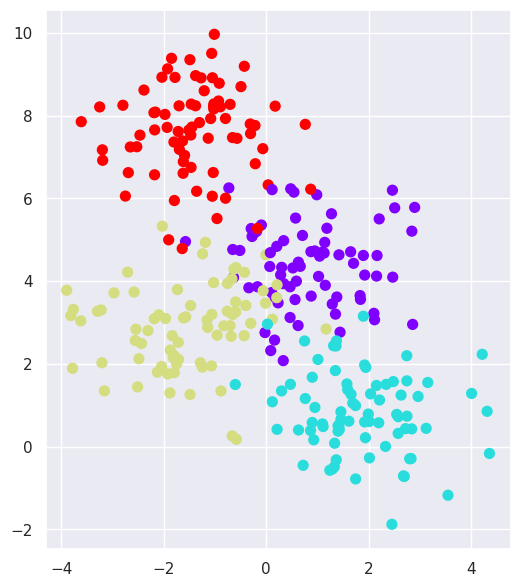

In [20]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate a synthetic 2D dataset with 350 samples and 4 centers
X, y = make_blobs(n_samples=350, centers=4, random_state=0, cluster_std=1.0)

# Split the data into training and testing sets
X_train, y_train = X[:300], y[:300]
X_test, y_test = X[300:], y[300:]

# Create a scatter plot of the training data
plt.figure(figsize=(6, 7))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='rainbow')
plt.show()

Let's experiment with our weak classifier. The key parameter to adjust in a **decision tree** is its **maximum depth**:

In [21]:
from ipywidgets import interact

# Create grids for the x and y coordinates spanning the specified ranges
gx = np.linspace(-4.5, 4.5, 256)  # x values ranging from -4.5 to 4.5
gy = np.linspace(-3, 11, 256)     # y values ranging from -3 to 11
gx, gy = np.meshgrid(gx, gy)      # Create a meshgrid from the x and y coordinates
gx, gy = gx.reshape(-1), gy.reshape(-1)  # Flatten the grids into 1D arrays

def fit_randomized_tree(depth=0):
    # Initialize and train a decision tree classifier with the specified maximum depth
    model_l = DecisionTreeClassifier(max_depth=depth, random_state=5)
    model_l.fit(X_train, y_train)

    # Predict labels for the grid points
    y_hat = model_l.predict(np.c_[gx, gy])  # Combine gx and gy into a Nx2 matrix for predictions

    # Plot the decision boundaries and training data
    plt.figure(figsize=(6, 7))
    plt.scatter(gx, gy, c=plt.cm.rainbow(y_hat / 4), alpha=0.2, s=10)  # Plot decision boundaries
    plt.scatter(X_train[:, 0], X_train[:, 1], s=60, c=y_train, cmap='rainbow')  # Plot training points
    plt.show()

# Use interact to create an interactive widget for adjusting the tree depth
interact(fit_randomized_tree, depth=(1, 15));  # Adjust tree depth to observe behavior

interactive(children=(IntSlider(value=1, description='depth', max=15, min=1), Output()), _dom_classes=('widget…

Unfortunately, the Scikit-learn implementation of the DecisionTree can only evaluate one feature at a time when constructing the tree. As a result, a decision tree alone is not capable of making discriminations using *oblique* decision boundaries.

We will now train **4 Decision Trees** on **4 different subsets (bags)** and evaluate whether we achieve the desired variance.

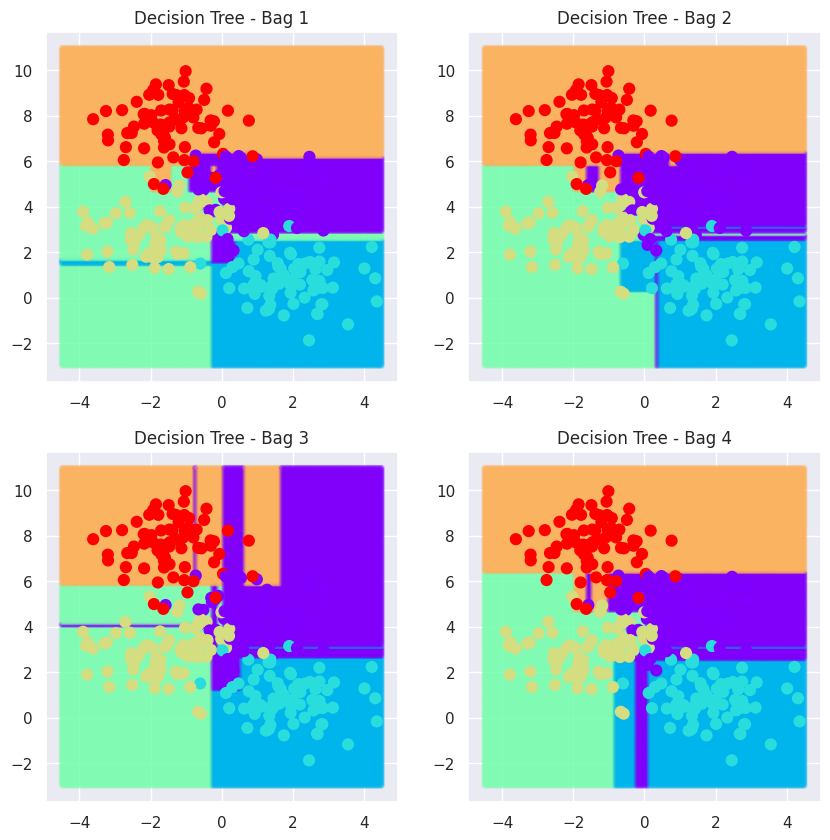

In [22]:
# Set random seed for reproducibility
np.random.seed(1)

# Train Decision Trees on different bootstrap samples
model_l = DecisionTreeClassifier(max_depth=15, random_state=5)
idx = np.random.randint(len(X_train), size=len(X_train))  # Sample for bag 1
model_l.fit(X_train[idx], y_train[idx])
y_hat_l = model_l.predict(np.c_[gx, gy])

model_m = DecisionTreeClassifier(max_depth=15, random_state=5)
idx = np.random.randint(len(X_train), size=len(X_train))  # Sample for bag 2
model_m.fit(X_train[idx], y_train[idx])
y_hat_m = model_m.predict(np.c_[gx, gy])

model_c = DecisionTreeClassifier(max_depth=15, random_state=5)
idx = np.random.randint(len(X_train), size=len(X_train))  # Sample for bag 3
model_c.fit(X_train[idx], y_train[idx])
y_hat_c = model_c.predict(np.c_[gx, gy])

model_g = DecisionTreeClassifier(max_depth=15, random_state=5)
idx = np.random.randint(len(X_train), size=len(X_train))  # Sample for bag 4
model_g.fit(X_train[idx], y_train[idx])
y_hat_g = model_g.predict(np.c_[gx, gy])

# Plot the decision boundaries for each trained model
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Plot for model_l
ax[0, 0].scatter(gx, gy, c=plt.cm.rainbow(y_hat_l / 4), alpha=0.2, s=10)
ax[0, 0].scatter(X_train[:, 0], X_train[:, 1], s=60, c=y_train, cmap='rainbow')
ax[0, 0].set_title('Decision Tree - Bag 1')

# Plot for model_m
ax[0, 1].scatter(gx, gy, c=plt.cm.rainbow(y_hat_m / 4), alpha=0.2, s=10)
ax[0, 1].scatter(X_train[:, 0], X_train[:, 1], s=60, c=y_train, cmap='rainbow')
ax[0, 1].set_title('Decision Tree - Bag 2')

# Plot for model_c
ax[1, 0].scatter(gx, gy, c=plt.cm.rainbow(y_hat_c / 4), alpha=0.2, s=10)
ax[1, 0].scatter(X_train[:, 0], X_train[:, 1], s=60, c=y_train, cmap='rainbow')
ax[1, 0].set_title('Decision Tree - Bag 3')

# Plot for model_g
ax[1, 1].scatter(gx, gy, c=plt.cm.rainbow(y_hat_g / 4), alpha=0.2, s=10)
ax[1, 1].scatter(X_train[:, 0], X_train[:, 1], s=60, c=y_train, cmap='rainbow')
ax[1, 1].set_title('Decision Tree - Bag 4')

plt.show()

Indeed, we observe high variance. For comparison, let's evaluate the score of one of these models on the test set:

In [23]:
model_c.score(X_test,y_test)

0.9

The score might appear high, but this is because the data is extremely straightforward.

The RandomForest classifier aggregates the predictions from the 4 models by taking a majority vote:

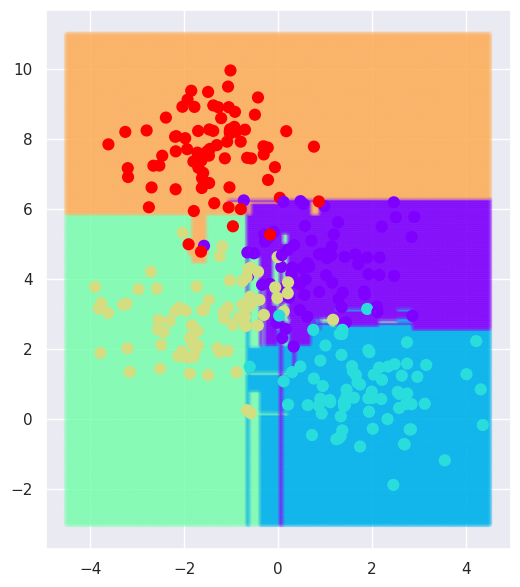

Test score = 0.96


In [24]:
# Create a grid of x and y values spanning the specified ranges
gx = np.linspace(-4.5, 4.5, 256)  # x values ranging from -4.5 to 4.5
gy = np.linspace(-3, 11, 256)     # y values ranging from -3 to 11
gx, gy = np.meshgrid(gx, gy)      # Generate a meshgrid from x and y values
gx, gy = gx.reshape(-1), gy.reshape(-1)  # Flatten the meshgrid into 1D arrays

# Initialize and train the RandomForest classifier with 4 trees and a maximum depth of 15
model_l = RandomForestClassifier(n_estimators=4, max_depth=15, random_state=3)
model_l.fit(X_train, y_train)

# Predict the class labels for the grid points
y_hat = model_l.predict(np.c_[gx, gy])  # Combine gx and gy into a Nx2 matrix for prediction

# Plot the decision boundaries and training data
plt.figure(figsize=(6, 7))
plt.scatter(gx, gy, c=plt.cm.rainbow(y_hat / 4), alpha=0.2, s=10)  # Plot decision boundaries
plt.scatter(X_train[:, 0], X_train[:, 1], s=60, c=y_train, cmap='rainbow')  # Plot training points
plt.show()

# Predict the class labels for the training and test sets
y_train_prediction = model_l.predict(X_train)
y_test_prediction = model_l.predict(X_test)

# Print the score of the RandomForest model on the test set
print('Test score =', model_l.score(X_test, y_test))


We observe a significantly improved score, and the RandomForest classifier provides a more coherent classification of the space.

**A brief note:** In this implementation of the RandomForest, the 4 Decision Trees used are different from the ones discussed earlier. We did not perform a majority vote among those trees, as our goal was to demonstrate a RandomForest implementation for future reference.

# Boosting - AdaBoost



Boosting is a technique that builds a series of classifier models, where each model in the sequence aims to correct the prediction errors made by the previous one. Additionally, each model is assigned a score reflecting its contribution.

By the end of the process, we have a sequence of classifiers, each one fine-tuned to address the mistakes of the previous models. The final prediction is made using a 'weighted voting' system, where each model's vote is weighted according to its score.

This process may seem complex at first, but it becomes more straightforward when we consider the AdaBoost algorithm:

*For simplicity, we will focus on binary classification.*

[Refer to the 'Understanding the Working of AdaBoost Algorithm' section here.](https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/)

The final prediction is given by:

$$H(x) = \text{sign}\left(\sum_i \alpha_i h_i(x)\right)$$

Where $\alpha_i$ represents the importance of the $i^{th}$ weak classifier, and $h_i(x)$ is its prediction.

**Why does it work?**

Stumps, which are simple models with high bias, often struggle to capture complex patterns. Boosting addresses this by incrementally adding layers of complexity. Each new model focuses on the hardest-to-predict instances from the current ensemble, thereby reducing bias and improving overall performance.

Let's apply the algorithm to a real dataset:

**Banknote Authentication Data Set**

**Data Set Information:**

This dataset was created using images taken from both genuine and counterfeit banknote-like specimens. The images were captured using an industrial camera typically employed for print inspection. Each final image has a resolution of 400x400 pixels. Due to the specific lens and distance from the object, the resulting grayscale images have a resolution of approximately 660 dpi. Features were extracted from these images using a Wavelet Transform tool.

(For more information on the Wavelet Transform, visit: https://en.wikipedia.org/wiki/Wavelet_transform)

**Attribute Information:**

1. **Variance of Wavelet Transformed Image:** High variance indicates sharp edges or detailed textures, while low variance suggests smoother areas.
2. **Skewness of Wavelet Transformed Image:** Indicates whether an image tends to be brighter or darker overall.
3. **Kurtosis of Wavelet Transformed Image:** High kurtosis implies the presence of areas significantly different from the rest, such as a very bright spot in an otherwise dark image.
4. **Entropy of Image:** High entropy corresponds to irregular patterns and unpredictability, while low entropy indicates repeated patterns.
5. **Class (integer):** 0 for authentic, 1 for fake.

In [25]:
import pandas as pd
# Load the dataset from the provided URL
dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', header=None)

# Assign column names to the dataset
dataset.columns = ['Variance_W.T.I', 'Skewness_W.T.I', 'Curtosis_W.T.I', 'I.Entropy', 'Class']

# Separate features (X) and labels (y)
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

# Print the shape of the feature set
print("Dataset size: ", X.shape)

# Display the dataset
dataset

Dataset size:  (1372, 4)


,Variance_W.T.I,Skewness_W.T.I,Curtosis_W.T.I,I.Entropy,Class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


The weak learner can be any type of classifier. Since we need to train them sequentially and the task cannot be parallelized, we used a 'Stump,' which is a decision tree with a depth of 1.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the weak classifier as a decision tree with a maximum depth of 1
weak_classifier = DecisionTreeClassifier(max_depth=1)

# Create the strong classifier using AdaBoost with 50 estimators
strong_classifier = AdaBoostClassifier(n_estimators=50, estimator=weak_classifier)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=314)

# Train the strong classifier on the training data
model = strong_classifier.fit(X_train, y_train)

print("score on the test set: ", model.score(X_test,y_test))

score on the test set:  1.0


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In this notebook, we've explored various classification techniques, but we haven't yet discussed how to fine-tune their hyperparameters to enhance their predictive performance. We'll address this topic in the "Validation" notebook.

Indeed an impressive result.

# **Exercise 2:** Can Machine Learning Understand Physics?
---

**Simple Physics Problem:** We have a scale with two arms. On the left arm, there is a weight placed at a certain distance from the center, and on the right arm, there is another weight at a different distance from the center. Will the scale tilt to the left, to the right, or remain balanced?

The data is four-dimensional, with each feature ranging from 1 to 5. The features are as follows: the *weight on the left arm*, the *distance of this weight from the center*, the *weight on the right arm*, and the *distance of this weight from the center*. The labels are $R$, $B$, or $L$, indicating *right*, *balanced*, or *left*, respectively.

1. Train a model to predict the label using the provided features. Then, plot the confusion matrix and correctly label the $x$ and $y$ axes with $R$, $B$, or $L$. Compute the accuracy on the test set.
2. Apply standard dimensionality reduction to visually compare predictions and ground truth, using different colors for $R$, $B$, and $L$. Identify the optimal combination of principal components to visualize the patterns in the prediction. Next, find the appropriate number of dimensions that minimizes information loss to avoid significant drops in accuracy.
3. Can you identify a particularly suitable 2D dimensionality reduction technique for this problem?
4. Train a model using the data projected into the reduced 2D space. What are the effects on performance?
5. Classify the entire 2D space and draw the true boundary separating the regions.

In [10]:
# Load the dataset from the provided URL
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data", header=None)

# Extract features and labels from the dataset
X = dataset.iloc[:, 1:].values  # Features: all columns except the first
y = dataset.iloc[:, 0].values   # Labels: the first column

### Solution 2.1:

Confusion Matrix: 
 [[ 0  2  7]
 [ 5 74  5]
 [ 1  0 63]]


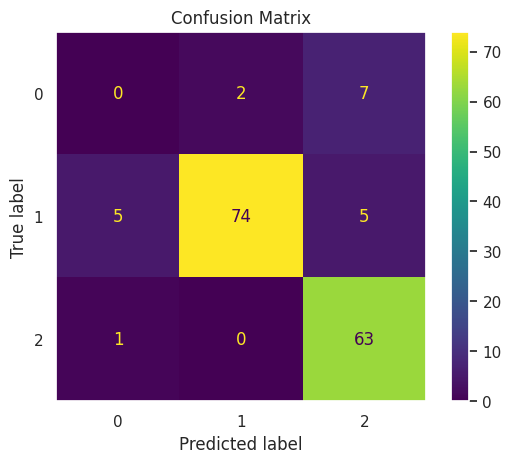

Accuracy:  0.8726114649681529


In [11]:
# Define the weak classifier with a maximum depth of 1
weak_classifier = DecisionTreeClassifier(max_depth=1, random_state=5);

# Build the strong classifier using AdaBoost with 50 estimators and the weak classifier
strong_classifier = AdaBoostClassifier(n_estimators=50, estimator=weak_classifier, algorithm="SAMME");

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=314)

# Train the strong classifier on the training data
model = strong_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Compute the confusion matrix for the predictions
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix: \n", cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

print("Accuracy: ", model.score(X_test, y_test))

Given the confusion matrix, it's not immediately clear which labels "$L$", "$R$", or "$B$" correspond to the first, second, or third rows/columns. How can we determine this?

To clarify, we should examine the predicted labels and compare them with the counts in the confusion matrix. Specifically, we see that there are $12$ predictions for label $0$, $79$ for label $1$, and $66$ for label $2$.

In [12]:
print(y_pred)
print("Number of times 'R' is predicted: ", len(y_pred[y_pred=='R']))

['L' 'R' 'L' 'L' 'R' 'R' 'L' 'L' 'L' 'R' 'L' 'R' 'L' 'L' 'L' 'L' 'B' 'L'
 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'L' 'L' 'L' 'B' 'L' 'R' 'L' 'R' 'R' 'L' 'R'
 'R' 'R' 'R' 'R' 'R' 'B' 'R' 'R' 'L' 'B' 'R' 'L' 'R' 'L' 'L' 'L' 'R' 'L'
 'L' 'L' 'L' 'R' 'R' 'R' 'L' 'L' 'L' 'R' 'R' 'B' 'L' 'L' 'L' 'R' 'R' 'R'
 'R' 'R' 'L' 'R' 'L' 'R' 'L' 'B' 'R' 'L' 'R' 'R' 'L' 'L' 'R' 'R' 'L' 'L'
 'R' 'R' 'L' 'L' 'R' 'R' 'L' 'L' 'R' 'L' 'R' 'R' 'L' 'L' 'L' 'L' 'L' 'L'
 'L' 'L' 'L' 'R' 'R' 'L' 'R' 'L' 'R' 'R' 'L' 'L' 'L' 'R' 'R' 'L' 'R' 'L'
 'R' 'R' 'L' 'R' 'R' 'R' 'L' 'R' 'R' 'R' 'L' 'L' 'R' 'L' 'R' 'L' 'L' 'L'
 'R' 'R' 'L' 'R' 'L' 'R' 'R' 'R' 'L' 'L' 'R' 'L' 'L']
Number of times 'R' is predicted:  75


From this, we can see that "$R$" corresponds to $2$, "$L$" corresponds to $1$, and "$B$" corresponds to $0$. We should now update the confusion matrix with these correct labels.

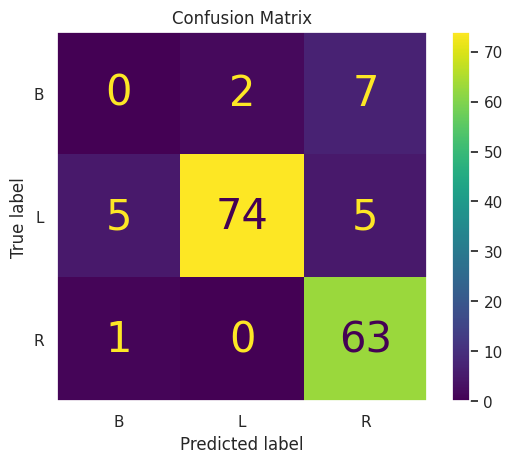

In [13]:
# Create a ConfusionMatrixDisplay object with the correct label names
disp = ConfusionMatrixDisplay(cm, display_labels=['B', 'L', 'R'])

# Plot the confusion matrix
disp.plot()

# Update font size for the plot
plt.rcParams.update({'font.size': 30})
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

### Solution 2.2:

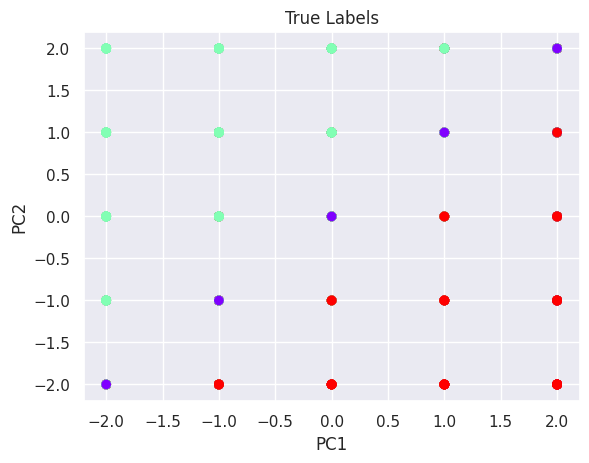

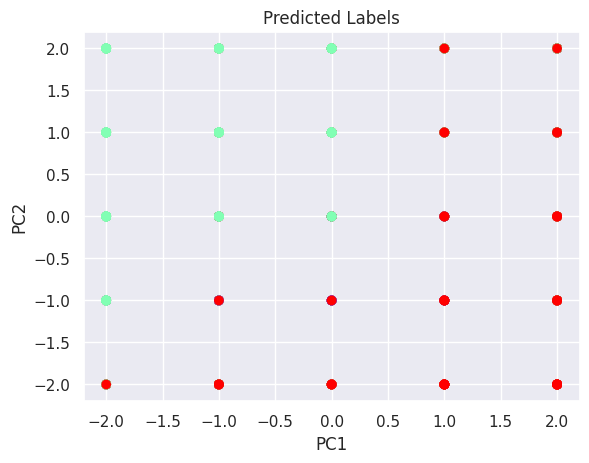

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert categorical labels to numerical values
y_numerical = np.zeros(len(y))
for i in range(len(y)):
    if y[i] == 'L':
        y_numerical[i] = 1
    elif y[i] == 'R':
        y_numerical[i] = 2
    elif y[i] == 'B':
        y_numerical[i] = 0

# Initialize PCA with 2 components and a fixed random state for reproducibility
pca = PCA(n_components=4, random_state=314)

# Project the data onto the first 2 principal components
X_proj = pca.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numerical, random_state=314)

# Train the strong classifier on the training data
model = strong_classifier.fit(X_train, y_train)

# Make predictions on the entire dataset
y_pred = model.predict(X)

# Plot the data points with colors representing the true labels
plt.figure()
plt.scatter(X_proj[:, 1], X_proj[:, 3], c=y_numerical, cmap='rainbow', alpha=1)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('True Labels')
plt.show();


# Plot the data points with colors representing the predicted labels
plt.figure()
plt.scatter(X_proj[:, 1], X_proj[:, 3], c=y_pred, cmap='rainbow', alpha=1)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Predicted Labels')
plt.show();

Now, let's determine the appropriate number of dimensions to train the model without sacrificing accuracy.

In [15]:
for i in range(len(pca.components_)):
  model = strong_classifier.fit(X_train[:, 0:i+1], y_train)
  # Make predictions on the entire dataset
  print("Accuracy using ", i+1, " dimensions: ", model.score(X_test[:, 0:i+1], y_test))

Accuracy using  1  dimensions:  0.7006369426751592
Accuracy using  2  dimensions:  0.7197452229299363
Accuracy using  3  dimensions:  0.8343949044585988
Accuracy using  4  dimensions:  0.8726114649681529


It appears there isn't a reasonable number of dimensions that describe the data without a noticeable drop in performance. Let's explore why:

Text(0, 0.5, 'explained variance ratio')

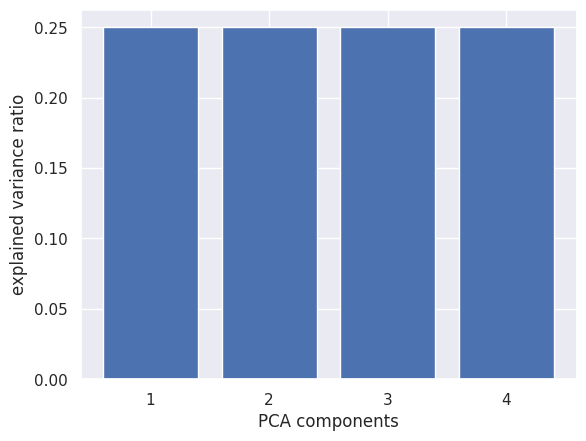

In [16]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.xlabel('PCA components')
plt.ylabel('explained variance ratio')

Each component has the same explained variance, making it impossible to use this dimensionality reduction without sacrificing performance. Is there another more effective dimensionality reduction method?

### Solutions 2.3, 2.4, and 2.5:

The dimensionality reduction approach to consider is:

1. **First Dimension**: Arm x Weight on the left
2. **Second Dimension**: Arm x Weight on the right

Confusion Matrix: 
 [[ 4  2  3]
 [ 6 77  1]
 [ 0  0 64]]
Accuracy:  0.9235668789808917


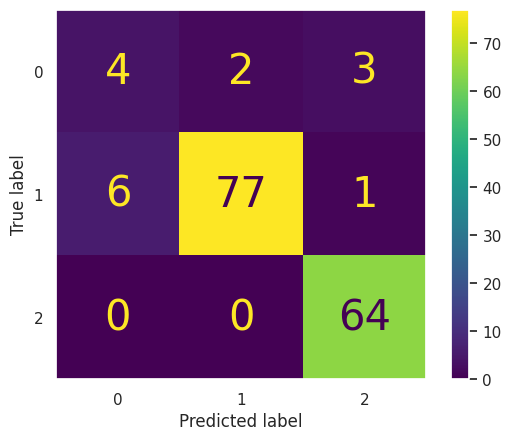

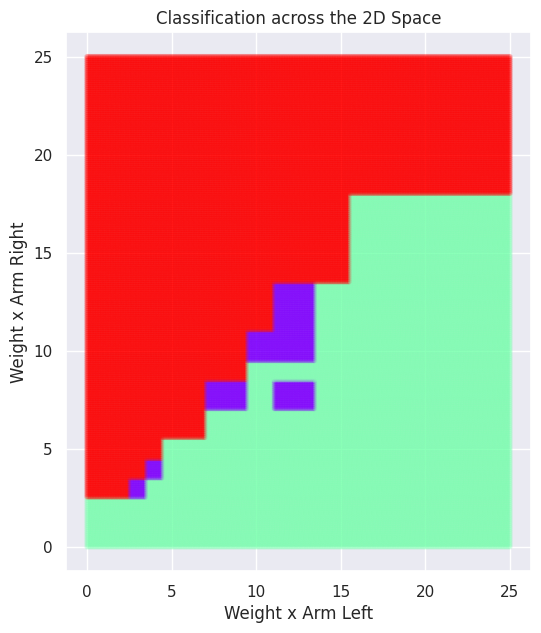

In [17]:
# Compute the 2D features by multiplying the weight and arm distance for both sides
X_2D = np.zeros((len(X[:, 1]), 2))
for i in range(len(X[:, 1])):
    X_2D[i, 0] = X[i, 0] * X[i, 1]  # Weight x Arm distance on the left
    X_2D[i, 1] = X[i, 2] * X[i, 3]  # Weight x Arm distance on the right

# Split the 2D data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_2D, y_numerical, random_state=314)

# Train the strong classifier on the 2D data
model = strong_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)
print("Accuracy: ", model.score(X_test, y_test))


# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.rcParams.update({'font.size': 30})
plt.grid(False)
plt.show()

# Create a meshgrid for plotting the decision boundary
gx = np.linspace(0, 25, 256)
gy = np.linspace(0, 25, 256)
gx, gy = np.meshgrid(gx, gy)
gx, gy = gx.reshape(-1), gy.reshape(-1)

# Predict class labels over the meshgrid
y_hat = model.predict(np.c_[gx, gy])

# Plot the decision boundary and classification of the 2D space
plt.figure(figsize=(6, 7))
plt.scatter(gx, gy, c=y_hat, alpha=0.2, s=10, cmap='rainbow')
plt.xlabel('Weight x Arm Left')
plt.ylabel('Weight x Arm Right')
plt.title('Classification across the 2D Space')
plt.show()

We don't observe the typical drop in performance that usually occurs when reducing the number of dimensions. This is because the embedding retains all the essential information needed to determine the scale's tilt.

It appears that the model has developed some form of *understanding* of the physics involved. It successfully identifies the regions where the scale leans left or right, as divided by the equilibrium line in violet.

Check out this video for more insights: [Watch Video](https://www.youtube.com/watch?v=2Bw5f4vYL98)